In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from utilities.nn_utils import *

from IPython.display import display, Markdown
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import dense_to_sparse

In [2]:
def winsorize_dataframe(df, lower_quantile=0.05, upper_quantile=0.95):
    df_winsorized = df.copy()
    limits = {}

    for column in df_winsorized.select_dtypes(include=[np.number]).columns:
        lower_limit = df_winsorized[column].quantile(lower_quantile)
        upper_limit = df_winsorized[column].quantile(upper_quantile)

        # Store the limits for each column
        limits[column] = {'min': lower_limit, 'max': upper_limit}

        # Cap the values to the calculated limits
        df_winsorized[column] = np.clip(df_winsorized[column], lower_limit, upper_limit)

    return df_winsorized, limits


def apply_winsorization_limits(df, limits):
    df_clipped = df.copy()

    for column, bound in limits.items():
        if column in df_clipped.columns:
            df_clipped[column] = np.clip(df_clipped[column], bound['min'], bound['max'])

    return df_clipped

In [3]:
data_path = Path("/Users/adamsulik/Workspace/qrt_datachallenge/data")

x_train = pd.read_csv(data_path / 'x_train_Lafd4AH.csv', index_col='ID')
y_train = pd.read_csv(data_path / 'y_train_JQU4vbI.csv', index_col='ID')

x_test = pd.read_csv(data_path / 'x_test_c7ETL4q.csv', index_col='ID')

train_stock = pd.Index(x_train['STOCK'].unique())
test_stock = pd.Index(x_test['STOCK'].unique())

In [4]:
df_melted = pd.concat([x_train, x_test])[['STOCK', 'DATE']+[f'RET_{i}' for i in range(1, 10)]]\
                .melt(id_vars=['STOCK', 'DATE'],var_name="RET_TYPE", value_name="RET_VALUE")
df_melted["RET_DATE"] = df_melted["RET_TYPE"] + "_" + df_melted["DATE"].astype(str)
df_pivot = df_melted.pivot(index="STOCK", columns="RET_DATE", values="RET_VALUE")
df_pivot = df_pivot.sort_index(axis=1)
df_pivot.columns.name = None
corr = df_pivot.T.corr().astype(float).fillna(0)

Create a graph embeddings

In [18]:
adj_tensor = torch.tensor(corr.values, dtype=torch.float)
edge_index, edge_weight = dense_to_sparse(adj_tensor)
data = Data(edge_index=edge_index, edge_attr=edge_weight, num_nodes=corr.shape[0])

embedding_dim = 64

node2vec = Node2Vec(
    data.edge_index,
    embedding_dim=embedding_dim,
    walk_length=20, 
    context_size=10,
    walks_per_node=10,
    num_nodes=data.num_nodes,
    p=1.0,
    q=1.0,
    sparse=True
).to('cpu')

optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

def train_node2vec():
    node2vec.train()
    optimizer.zero_grad()
    pos_rw, neg_rw = node2vec.sample(batch=32)
    loss = node2vec.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
epochs = 3000  # Increase for better results
for epoch in range(1, epochs+1):
    loss = train_node2vec()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}")

Epoch: 100, Loss: 6.1735
Epoch: 200, Loss: 6.0320
Epoch: 300, Loss: 5.6950
Epoch: 400, Loss: 4.9246
Epoch: 500, Loss: 4.6424
Epoch: 600, Loss: 3.8336
Epoch: 700, Loss: 3.8807
Epoch: 800, Loss: 3.6931
Epoch: 900, Loss: 3.1961
Epoch: 1000, Loss: 2.9341
Epoch: 1100, Loss: 2.9455
Epoch: 1200, Loss: 2.5902
Epoch: 1300, Loss: 2.4432
Epoch: 1400, Loss: 2.4179
Epoch: 1500, Loss: 2.1447
Epoch: 1600, Loss: 2.0443
Epoch: 1700, Loss: 2.0649
Epoch: 1800, Loss: 1.8094
Epoch: 1900, Loss: 1.8710
Epoch: 2000, Loss: 1.8369
Epoch: 2100, Loss: 1.7939
Epoch: 2200, Loss: 1.7153
Epoch: 2300, Loss: 1.6892
Epoch: 2400, Loss: 1.6754
Epoch: 2500, Loss: 1.6846
Epoch: 2600, Loss: 1.5904
Epoch: 2700, Loss: 1.5680
Epoch: 2800, Loss: 1.6126
Epoch: 2900, Loss: 1.5340
Epoch: 3000, Loss: 1.5496


In [19]:
node2vec.eval()
emb = node2vec.embedding.weight.detach()

In [20]:
def get_top_k_neighbors(embeddings, k=10):
    num_nodes = embeddings.size(0)
    emb_norm = F.normalize(embeddings, dim=1)  # shape [N, d]
    sim_matrix = emb_norm @ emb_norm.T
    top_k_indices = []
    top_k_similarities = []

    for i in range(num_nodes):
        sim_matrix[i, i] = float('-inf')
        sim_scores = sim_matrix[i]
        sim_values, sim_idxs = torch.topk(sim_scores, k, largest=True)
        top_k_indices.append(sim_idxs.tolist())
        top_k_similarities.append(sim_values.tolist())

    return top_k_indices, top_k_similarities


k = 150
top_k_indices, top_k_distances = get_top_k_neighbors(emb, k=k)
rows = []
for node_id in range(corr.shape[0]):
    neighbors = top_k_indices[node_id]
    distances = top_k_distances[node_id]
    rows.append({
        "node": node_id,
        "neighbors": neighbors,
        "distances": distances
    })

neighbors_df = pd.DataFrame(rows)

In [21]:
def compute_ret_stats(
    df_prices: pd.DataFrame, 
    neighbors_df: pd.DataFrame, 
    days_back: int = 5
) -> pd.DataFrame:
    ret_columns = [f'RET_{i}' for i in range(1, days_back + 1)]
    vol_columns = [f'VOLUME_{i}' for i in range(1, days_back + 1)]
    df_prices = df_prices.copy()

    # for each node retireve nn and aggregate RET_1 and VOLUME_1
    results = []
    for row in neighbors_df.itertuples(index=False):
        node_id = row.node
        neighbor_ids = row.neighbors  # list of stock IDs
        relevant_stocks = [node_id] + neighbor_ids
        
        # Subset df_prices for these stocks
        sub_df = df_prices[df_prices['STOCK'].isin(relevant_stocks)]
        if sub_df.empty:
            # No data => skip or produce an empty DataFrame
            continue
        
        # Group by DATE and compute aggregates
        grouped = (
            sub_df
            .groupby('DATE', as_index=False)
            .agg(
                mean_RET_1=('RET_1', 'mean'),
                std_RET_1=('RET_1', 'std'),
                mean_VOL_1=('VOLUME_1', 'mean'),
                std_VOL_1=('VOLUME_1', 'std')
            )
        )

        # Insert 'node' column so we know which node this group belongs to
        grouped.insert(0, 'node', node_id)
        results.append(grouped)

    if results:
        results_df = pd.concat(results, ignore_index=True)
    else:
        # In case everything was empty
        results_df = pd.DataFrame(columns=[
            'node', 'DATE', 'mean_RET_1', 'std_RET_1', 'mean_VOL_1', 'std_VOL_1'
        ])

    return results_df.rename(columns={'node': 'STOCK'})

# Preprocess the data

In [28]:
def winsorize_dataframe(df, lower_quantile=0.05, upper_quantile=0.95):
    df_winsorized = df.copy()
    limits = {}

    for column in df_winsorized.select_dtypes(include=[np.number]).columns:
        lower_limit = df_winsorized[column].quantile(lower_quantile)
        upper_limit = df_winsorized[column].quantile(upper_quantile)

        # Store the limits for each column
        limits[column] = {'min': lower_limit, 'max': upper_limit}

        # Cap the values to the calculated limits
        df_winsorized[column] = np.clip(df_winsorized[column], lower_limit, upper_limit)

    return df_winsorized, limits


def apply_winsorization_limits(df, limits):
    df_clipped = df.copy()

    for column, bound in limits.items():
        if column in df_clipped.columns:
            df_clipped[column] = np.clip(df_clipped[column], bound['min'], bound['max'])

    return df_clipped


def column2onehot(x_table, column, ohencoder=None):
    if ohencoder is None:
        ohencoder = OneHotEncoder(handle_unknown='ignore').fit(x_table[column].values.reshape(-1, 1))
    ohe_values = ohencoder.transform(x_table[column].values.reshape(-1, 1)).toarray()
    column_names = [f'{column}_ohe_{i}' for i in range(ohe_values.shape[1])]
    ohe_df = pd.DataFrame(index=x_table.index, columns=column_names)
    ohe_df.iloc[:] = ohe_values
    return ohe_df, ohencoder

In [31]:
def preprocess_data(x_df, neighbors_df, daysback=5, ohencoder=None, limits=None, arb_group='SECTOR'):
    x_df = x_df.copy()
    ret_columns = [f'RET_{i}' for i in range(1, daysback+1)]
    vol_columns = [f'VOLUME_{i}' for i in range(1, daysback+1)]
    numerical_columns = ret_columns + vol_columns
    
    x_df = x_df.copy()[['DATE', 'STOCK', 'SECTOR', 'INDUSTRY']+ret_columns+vol_columns]
    if not limits:
        x_df.loc[:, numerical_columns], limits = winsorize_dataframe(x_df[numerical_columns], lower_quantile=0.01, upper_quantile=0.99)
    else:
        x_df = apply_winsorization_limits(x_df, limits)
    x = x_df.fillna(0)
    nn_stats = compute_ret_stats(x, neighbors_df, daysback)
    x = x.merge(nn_stats, on=['DATE', 'STOCK'])
    
    sector_mean = x_df.groupby(['DATE', arb_group])[['RET_1', 'VOLUME_1']].mean().reset_index().rename(
        columns={'RET_1': f'RET_1_{arb_group}', 'VOLUME_1': f'VOLUME_1_{arb_group}'}
    )
    sector_mean = x_df.merge(sector_mean, on=['DATE', arb_group])[['DATE', 'STOCK', f'RET_1_{arb_group}', f'VOLUME_1_{arb_group}']]
    x = x.merge(sector_mean, on=['DATE', 'STOCK'])
    group_encoding, ohencoder = column2onehot(x, arb_group, ohencoder)
    x = x.join(group_encoding)
    x.index = x_df.index
    return x, limits, ohencoder

daysback = 10
train, winsor_limits, ohencoder = preprocess_data(x_train, neighbors_df, daysback)
test, _, _ = preprocess_data(x_test, neighbors_df, daysback, ohencoder=ohencoder, limits=winsor_limits)

# Train model on trees

In [80]:
ret_columns = [f'RET_{i}' for i in range(1, daysback+1)]
vol_columns = [f'VOLUME_{i}' for i in range(1, daysback+1)]
arb_group_avg_columns = ['RET_1_SECTOR', 'VOLUME_1_SECTOR']
features = ret_columns + vol_columns + arb_group_avg_columns + ['mean_RET_1', 'std_RET_1', 'mean_VOL_1', 'std_VOL_1']

X_train = train[features]
Y = y_train['RET']

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = Y.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = Y.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 52.36%
Fold 2 - Accuracy: 50.70%
Fold 3 - Accuracy: 50.87%
Fold 4 - Accuracy: 51.56%
Accuracy: 51.37% [50.72 ; 52.03] (+- 0.65)


<Axes: >

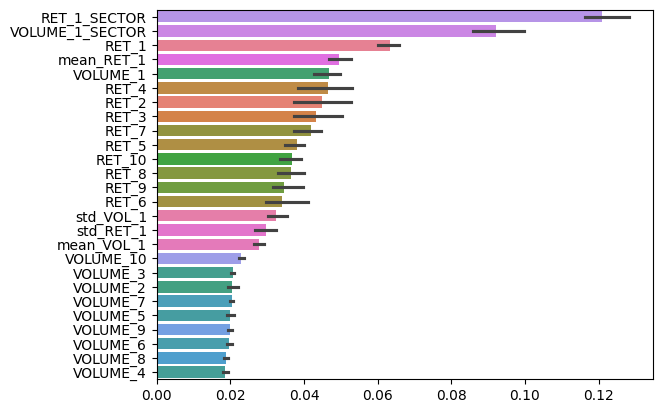

In [81]:
import seaborn as sns

feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

Generate outputs

In [82]:
output_storage_path = data_path.parent / 'outputs' / 'n2v_approach'
output_storage_path.mkdir(parents=True, exist_ok=True)
output_fname = f'nn{k}daysback{daysback}.csv'

X_test = test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = 'RET'

submission.to_csv(output_storage_path / output_fname, index=True, header=True)

/Users/adamsulik/Workspace/qrt_datachallenge/.dcvenv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Train model on neural network

In [58]:
SEED = 42
NUM_WORKERS = 10
PRINT_EVERY=1
EPOCHS = 30


ret_columns = [f'RET_{i}' for i in range(1, daysback+1)]
vol_columns = [f'VOLUME_{i}' for i in range(1, daysback+1)]
arb_group_avg_columns = ['RET_1_SECTOR', 'VOLUME_1_SECTOR']
ohe_columns = [c for c in train.columns if c.startswith('SECTOR_ohe_')]
numerical_columns = ret_columns + vol_columns + arb_group_avg_columns + ['mean_RET_1', 'std_RET_1', 'mean_VOL_1', 'std_VOL_1']
features = numerical_columns

# device = choose_device()
device='cpu'
learning_rate = 1e-3
model_hidden_layers = [32, 16]
dropout_rate = [0.6, 0.4]
X = train[features].astype(float).fillna(0).values
Y = y_train['RET'].astype(int).values
dates_arr = x_train['DATE']


# Standarize numerical values
scaler = StandardScaler().fit(X[:, :len(numerical_columns)])
X[:, :len(numerical_columns)] = scaler.transform(X[:, :len(numerical_columns)])

# run k-fold cv
cv_results = run_k_fold_training(X, Y, random_seed=SEED, num_workers=NUM_WORKERS, device=device, epochs=EPOCHS,
                                 split_type='date', date_array=dates_arr, print_every_epoch=PRINT_EVERY,
                                 lr=learning_rate, model_hidden_layers=model_hidden_layers, dropout_rate=dropout_rate
                                )

Training on cpu

Fold 1/4
Train/Val ratio: 3.09
09:31:14	  -- Epoch 1: Training Loss = 0.6939 | Training Accuracy = 0.5037 | Validation Accuracy = 0.5152
09:31:26	  -- Epoch 2: Training Loss = 0.6928 | Training Accuracy = 0.5103 | Validation Accuracy = 0.5188
09:31:37	  -- Epoch 3: Training Loss = 0.6927 | Training Accuracy = 0.5119 | Validation Accuracy = 0.5115
09:31:49	  -- Epoch 4: Training Loss = 0.6925 | Training Accuracy = 0.5131 | Validation Accuracy = 0.5181
09:32:01	  -- Epoch 5: Training Loss = 0.6925 | Training Accuracy = 0.5129 | Validation Accuracy = 0.5135
09:32:12	  -- Epoch 6: Training Loss = 0.6925 | Training Accuracy = 0.5133 | Validation Accuracy = 0.5195
09:32:24	  -- Epoch 7: Training Loss = 0.6924 | Training Accuracy = 0.5151 | Validation Accuracy = 0.5196
09:32:36	  -- Epoch 8: Training Loss = 0.6923 | Training Accuracy = 0.5158 | Validation Accuracy = 0.5206
09:32:48	  -- Epoch 9: Training Loss = 0.6923 | Training Accuracy = 0.5159 | Validation Accuracy = 0.516

In [59]:
cv_results = pd.DataFrame(cv_results)#.set_index('fold')
avg_acc = cv_results['accuracy'].mean()
std_acc = cv_results['accuracy'].std()

upper_bound_acc = avg_acc + std_acc
lower_bound_acc = avg_acc - std_acc

print(f'Accuracy: {avg_acc:.5f} [{lower_bound_acc:.5f}; {upper_bound_acc:.5f}] (+- {std_acc:.6f}), based on 4 kfolds')

Accuracy: 0.51446 [0.50569; 0.52322] (+- 0.008768), based on 4 kfolds


Train the model

In [66]:
EPOCHS = 100
BATCH_SIZE = 64
SEED = 42
VAL_SPLIT = 0.1

output_storage_path = data_path.parent / 'outputs' / 'n2v_approach'
output_storage_path.mkdir(parents=True, exist_ok=True)
experiment_name = f'nn{k}daysback{daysback}_nn'

learning_rate = 1e-3
model_hidden_layers = [32, 16]
dropout_rate = [0.6, 0.6]

ret_columns = [f'RET_{i}' for i in range(1, daysback+1)]
vol_columns = [f'VOLUME_{i}' for i in range(1, daysback+1)]
arb_group_avg_columns = ['RET_1_SECTOR', 'VOLUME_1_SECTOR']
numerical_columns = ret_columns + vol_columns + arb_group_avg_columns + ['mean_RET_1', 'std_RET_1', 'mean_VOL_1', 'std_VOL_1']
features = numerical_columns

dates_arr = x_train['DATE']

device = choose_device()

X = train[features].fillna(0).values
Y = y_train['RET'].astype(int).values

model_checkpoint, model_stats_df = full_dataset_training(
    X=X, Y=Y,
    numerical_columns=numerical_columns,
    output_storage_path=output_storage_path,
    bestmodel_exp_name=experiment_name,
    val_split=VAL_SPLIT,
    model_hidden_layers=model_hidden_layers,
    dropout_rate=dropout_rate,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    seed=SEED,
    split_type='date',
    date_array=dates_arr,
    print_every_epoch=PRINT_EVERY,
)

10:05:03	  -- Epoch 1: 	Training Loss = 0.6945 | Training Accuracy = 0.5033 | Validation Loss = 0.6931 | Validation Accuracy = 0.5007
10:05:21	  -- Epoch 2: 	Training Loss = 0.6930 | Training Accuracy = 0.5072 | Validation Loss = 0.6927 | Validation Accuracy = 0.5110
10:05:39	  -- Epoch 3: 	Training Loss = 0.6927 | Training Accuracy = 0.5120 | Validation Loss = 0.6925 | Validation Accuracy = 0.5091
10:05:58	  -- Epoch 4: 	Training Loss = 0.6927 | Training Accuracy = 0.5114 | Validation Loss = 0.6925 | Validation Accuracy = 0.5095
10:06:16	  -- Epoch 5: 	Training Loss = 0.6925 | Training Accuracy = 0.5145 | Validation Loss = 0.6927 | Validation Accuracy = 0.5092
10:06:35	  -- Epoch 6: 	Training Loss = 0.6924 | Training Accuracy = 0.5158 | Validation Loss = 0.6929 | Validation Accuracy = 0.5109
10:06:53	  -- Epoch 7: 	Training Loss = 0.6924 | Training Accuracy = 0.5168 | Validation Loss = 0.6928 | Validation Accuracy = 0.5057
10:07:12	  -- Epoch 8: 	Training Loss = 0.6923 | Training Accu

In [72]:
experiment_name = f'nn{k}daysback{daysback}_nn'
checkpoint_path = output_storage_path / (experiment_name+'.pt')

X_test = test[features].values
preds = load_model_and_predict(checkpoint_path, X_test, numerical_columns, model_hidden_layers=model_hidden_layers)

test_with_preds = test.copy()
test_with_preds['preds'] = preds
test_with_preds['RET'] = test_with_preds['preds'] > 0.5
test_with_preds

/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/nn_utils.py:553: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [79]:
test_with_preds['RET'].to_csv(output_storage_path / f'{experiment_name}.csv')